## Analyze Altitude Changes

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import geopandas as gpd

import os, glob
import multiprocessing

import cv2
import numpy as np
import matplotlib.pyplot as plt

import exiftool
import datetime

import rasterio

### Helper Functions

In [3]:
import glob, os
from GPSPhoto import gpsphoto
import pandas as pd

def load_img_fn_and_meta(img_dir, count, start):
    df = pd.read_csv(img_dir + '/log.csv')
    df['filename'] = df['SourceFile'].str.split('/').str[-1]
    df = df.set_index('filename')
    #print(df.head())
    i = 0
    j = 0
    if not count:
        count = 10000
    img_metadata = []
    imgs = []
    for file in glob.glob(img_dir + "/*.tif"):
        if j >= count:
            pass
        elif i < start:
            pass
        else:
            imgs.append(file)
            md = gpsphoto.getGPSData(file)
            filename = file.split('/')[-1]
            md['filename'] = filename
            # this isn't correctly loaded into the exifdata so pulling it into my own md
            md['yaw']   = (df.loc[filename]['    GPSImgDirection'] + 360) % 360
            md['pitch'] = (df.loc[filename]['GPSPitch'] + 360) % 360
            md['roll']  = (df.loc[filename]['GPSRoll'] + 360) % 360
            
            img_metadata.append(md)
            j += 1
        i += 1
        
    return(imgs, img_metadata)

In [4]:
def load_images(img_list):
    all_imgs = []
    for im in img_list:
        with rasterio.open(im, 'r') as src:
            all_imgs.append(src.read())
    return(all_imgs)

### Primary Processing Function

In [5]:
import math

def retrieve_imgs_and_metadata(img_dir, count=None, start=0, altitude_cutoff = 0):
    img_fns, img_metadata = load_img_fn_and_meta(img_dir, count=count, start=start)
    idxs = []
    for i, md in enumerate(img_metadata):
        if md['Altitude'] > altitude_cutoff:
            idxs.append(i)
    
    imgs = load_images([img_fns[i] for i in idxs])
    imgs = np.array(imgs) / 32768 # this corrects it back to reflectance
    # TODO confirm with Anna that this is appropriate
    img = imgs / math.pi # this corrects from reflectance to remote sensing reflectance
    print('Output shape is: ', imgs.shape)

    # give the metadata the index of each image it is connected to so that I can sort them later
    img_metadata = [img_metadata[i] for i in idxs]
    i = 0
    for md in img_metadata:
        md['id'] = i
        i += 1
    return(imgs, img_metadata)

In [6]:
surface_dir = os.path.join('data', '20210317_duml_360_altitude_testing', 'altitude_test', 'varying_altitude', 'stacks')

In [9]:
sea_imgs, sea_img_metadata = retrieve_imgs_and_metadata(surface_dir, count=100, start=0, altitude_cutoff=0)

/home/clifgray/anaconda3/envs/micasense_ocean_color/lib/python3.7/site-packages/rasterio/__init__.py:218: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Output shape is:  (50, 5, 945, 1268)


In [61]:
def key_function(item_dictionary):
    '''Extract datetime string from given dictionary, and return the parsed datetime object'''
    datetime_string = item_dictionary['UTC-Time']
    return datetime.datetime.strptime(datetime_string, '%H:%M:%S')

In [72]:
sea_img_metadata.sort(key=key_function)

only grab metadata

In [14]:
fns, mds = load_img_fn_and_meta(surface_dir, count=None, start=0)

In [15]:
mds[0]

{'Latitude': 34.71673611111111,
 'Longitude': -76.67349166666668,
 'Altitude': 1.9,
 'UTC-Time': '18:27:19',
 'Date': '03/30/2021',
 'filename': 'jz0JNiy0rjpbG2ocykBR.tif',
 'yaw': 274.74837839976607,
 'pitch': 23.98295930007771,
 'roll': 345.0410321830692}

In [16]:
len(mds)

50

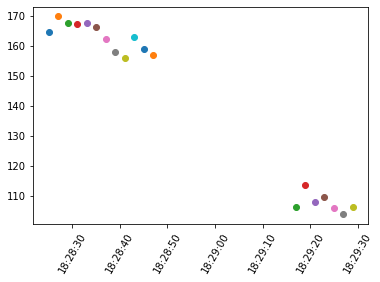

In [76]:
import datetime

for md in sky_img_metadata:
    plt.scatter(datetime.datetime.strptime(md['UTC-Time'], '%H:%M:%S'), md['yaw'])
    plt.xticks(rotation=60)

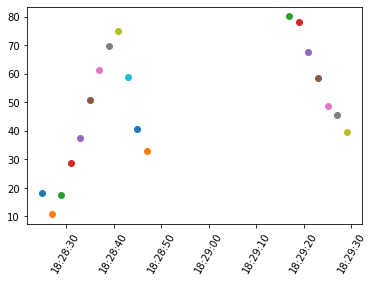

In [77]:
for md in sky_img_metadata:
    plt.scatter(datetime.datetime.strptime(md['UTC-Time'], '%H:%M:%S'), md['pitch'])
    plt.xticks(rotation=60)

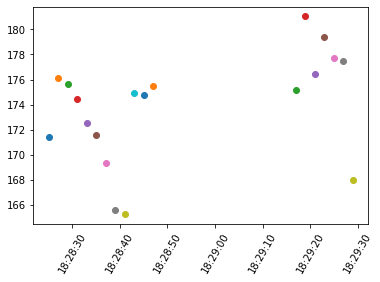

In [78]:
for md in sky_img_metadata:
    plt.scatter(datetime.datetime.strptime(md['UTC-Time'], '%H:%M:%S'), md['roll'])
    plt.xticks(rotation=60)

## Detect squares in each image

In [7]:
# import the necessary packages
import cv2
class ShapeDetector:
    def __init__(self):
        pass
    def detect(self, c):
        # initialize the shape name and approximate the contour
        shape = "unidentified"
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.04 * peri, True)
        
        # if the shape is a triangle, it will have 3 vertices
        if len(approx) == 3:
            shape = "triangle"
        # if the shape has 4 vertices, it is either a square or
        # a rectangle
        elif len(approx) == 4:
            # compute the bounding box of the contour and use the
            # bounding box to compute the aspect ratio
            (x, y, w, h) = cv2.boundingRect(approx)
            ar = w / float(h)
            # a square will have an aspect ratio that is approximately
            # equal to one, otherwise, the shape is a rectangle
            shape = "square" if ar >= 0.95 and ar <= 1.05 else "rectangle"
        # if the shape is a pentagon, it will have 5 vertices
        elif len(approx) == 5:
            shape = "pentagon"
        # otherwise, we assume the shape is a circle
        else:
            shape = "circle"
        # return the name of the shape
        return shape

In [70]:
src = rasterio.open('data/20210317_duml_360_altitude_testing/altitude_test/varying_altitude/IMG_0397_2.tif')

In [71]:
image = src.read(1)
image.shape, image.dtype

((1544, 2064), dtype('uint16'))

In [72]:
import imutils

In [73]:
np.max(image)

65504

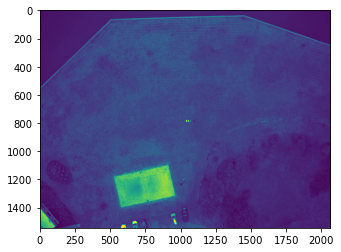

In [74]:
plt.imshow(image)

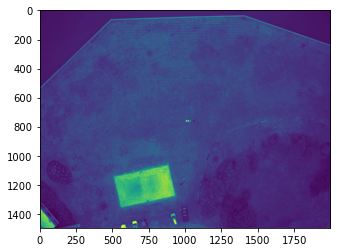

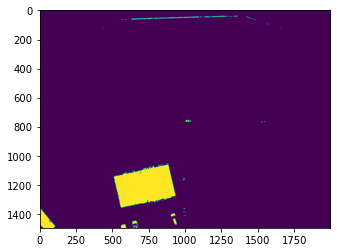

In [75]:
# load the image and resize it to a smaller factor so that
# the shapes can be approximated better
#image = cv2.imread(args["image"])
resized = imutils.resize(image, width=2000)
ratio = image.shape[0] / float(resized.shape[0])
# convert the resized im|age to grayscale, blur it slightly,
# and threshold it
cvuint8 = cv2.convertScaleAbs(resized, alpha=(255.0/65535.0))
blurred = cv2.GaussianBlur(cvuint8, (5, 5), 0)
thresh = cv2.threshold(blurred, 120, 255, cv2.THRESH_BINARY)[1]
plt.imshow(cvuint8)
plt.show()
plt.imshow(thresh)
plt.show()

# find contours in the thresholded image and initialize the
# shape detector
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,
    cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
sd = ShapeDetector()

triangle


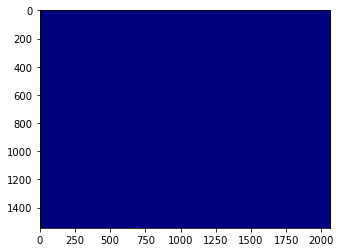

circle


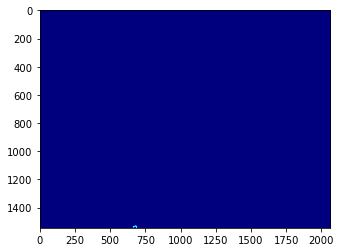

pentagon


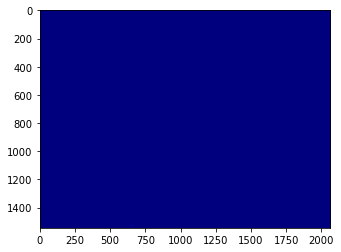

rectangle


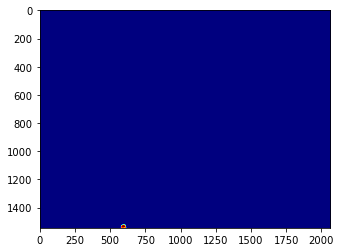

pentagon


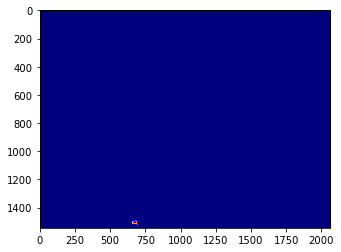

circle


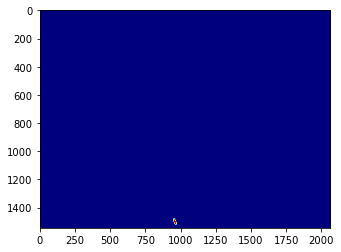

circle


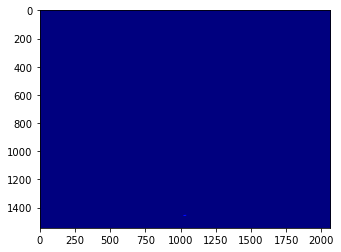

pentagon


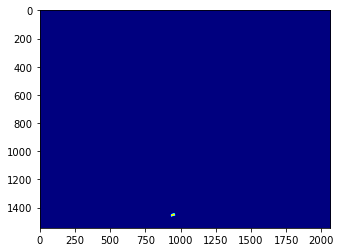

circle


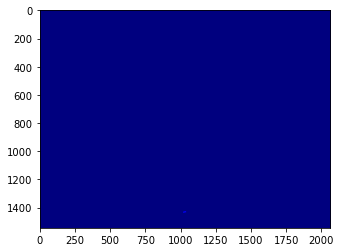

triangle


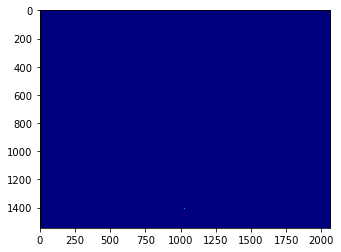

triangle


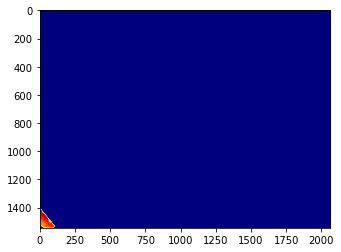

pentagon


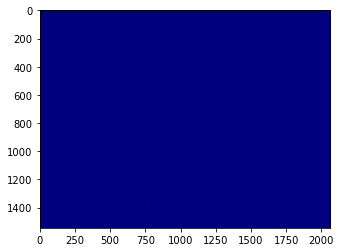

triangle


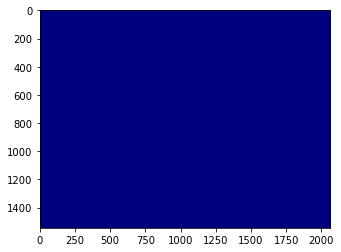

square


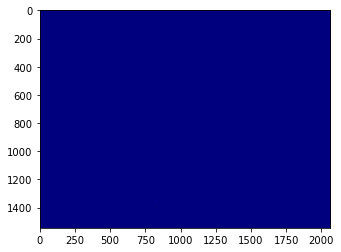

rectangle


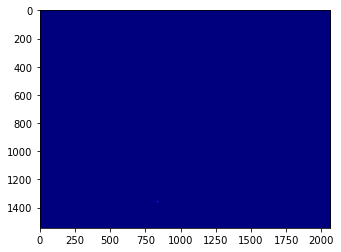

pentagon


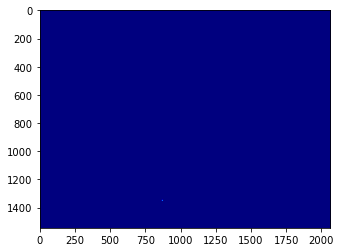

rectangle


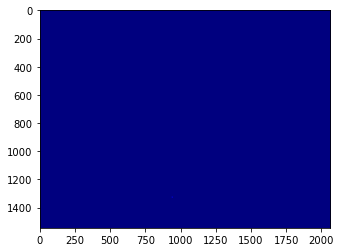

circle


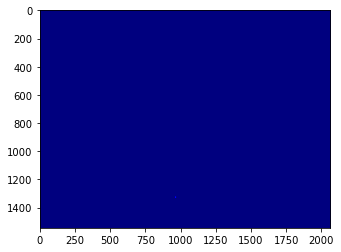

rectangle


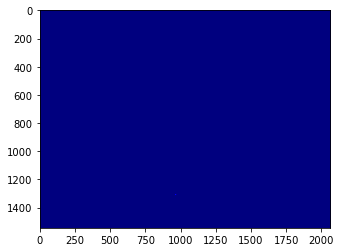

rectangle


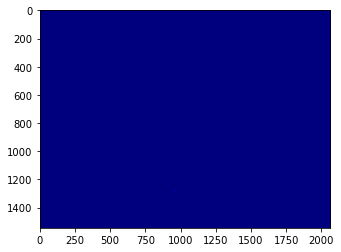

circle


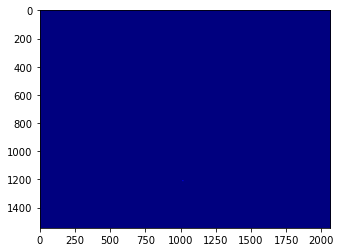

circle


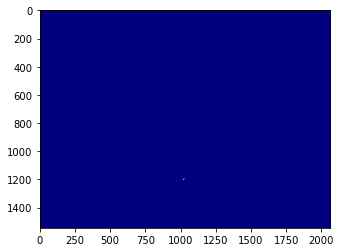

rectangle


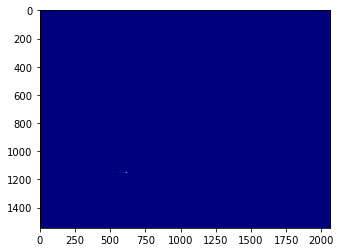

pentagon


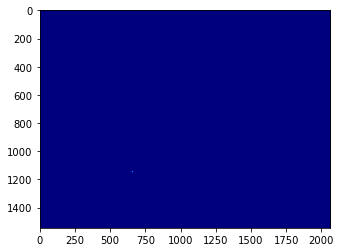

ZeroDivisionError: float division by zero

In [76]:
# loop over the contours
for c in cnts:
    # compute the center of the contour, then detect the name of the
    # shape using only the contour
    M = cv2.moments(c)
    cX = int((M["m10"] / M["m00"]) * ratio)
    cY = int((M["m01"] / M["m00"]) * ratio)
    shape = sd.detect(c)
    # multiply the contour (x, y)-coordinates by the resize ratio,
    # then draw the contours and the name of the shape on the image
    c = c.astype("float")
    c *= ratio
    c = c.astype("int")
    #cv2.drawContours(image, [c], -1, (255, 0, 255), 2)
    
    mask = np.zeros_like(image) # Create mask where white is what we want, black otherwise
    cv2.drawContours(mask, [c], -1, 255, -1) # Draw filled contour in mask
    out = np.zeros_like(image) # Extract out the object and place into output image
    out[mask == 255] = image[mask == 255]
    
    
    print(shape)
    # show the output image
    plt.imshow(out, cmap='jet')
    plt.show()

In [43]:
image

array([[7200, 6192, 5744, ..., 9456, 9312, 7680],
       [7488, 6768, 7008, ..., 9472, 8912, 7568],
       [7664, 7392, 8000, ..., 8416, 6976, 5728],
       ...,
       [7600, 7840, 7360, ..., 5600, 5680, 5584],
       [7936, 7696, 7424, ..., 5680, 6144, 6720],
       [7136, 6576, 6640, ..., 5632, 6320, 8224]], dtype=uint16)

In [40]:
mask = np.zeros_like(image) # Create mask where white is what we want, black otherwise
cv2.drawContours(mask, contours, idx, 255, -1) # Draw filled contour in mask
out = np.zeros_like(img) # Extract out the object and place into output image
out[mask == 255] = img[mask == 255]

(162, 83, 33, 32)